<a href="https://colab.research.google.com/github/jakewalter/ok_injection_earthquakes/blob/main/injection_1point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

674
3651
24156
68060


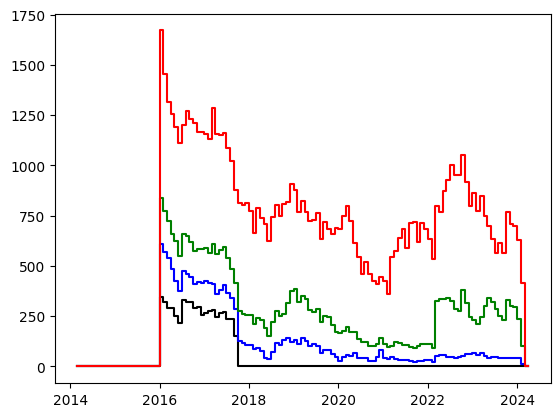

5.0 km from the epicenter
10.0 km from the epicenter
15.0 km from the epicenter
20.0 km from the epicenter


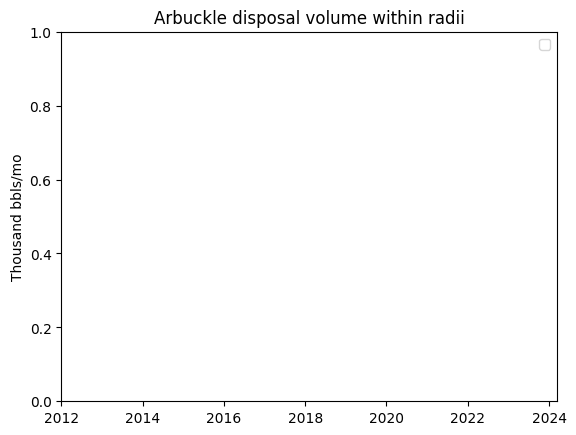

<Figure size 640x480 with 0 Axes>

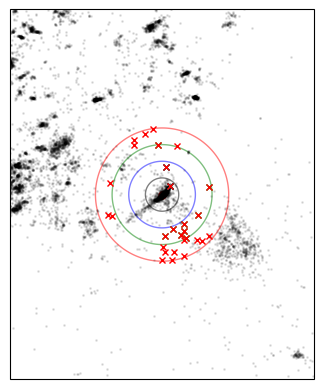

In [10]:
!pip install wget
!pip install cartopy

import matplotlib.pyplot as plt
import pandas as pd
#import fiona
import numpy as np

import datetime
import wget


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

url = 'https://wichita.ogs.ou.edu/eq/data/injection_data.h5'
filename = wget.download(url)

welldat = pd.read_hdf('injection_data.h5', 'welldat')
injdat = pd.read_hdf('injection_data.h5', 'injdat')

#### earthquake
catdf = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/complete/complete.csv')
catdf = catdf.reset_index(drop=True)
catdf['origintime'] = pd.to_datetime(catdf['origintime'])
catdf['magnitude'] = catdf['magnitude'].astype(str).replace("None", "0").astype(float)
catdf['magnitude'] = catdf['magnitude'].astype(float)
#catdf = catdf[(catdf['origintime']>time1) & (catdf['origintime']<time2)]
catdf.sort_values(by=['origintime'], inplace=True)
catdf = catdf.reset_index(drop=True)




lat1, lon1 = 35.5343, -96.7638


distvar = [5000, 10000, 15000, 20000] #radii from point, m
colorind = ['k','b','g','r']

mydate = datetime.datetime.now()
current = datetime.datetime(mydate.year, mydate.month, 1)
next_month = datetime.datetime(mydate.year + int(mydate.month / 12), ((mydate.month % 12) + 1), 1)
enddate = str(next_month.month)+'/1/'+str(next_month.year)

plt.figure()
possibles = np.zeros((len(injdat['Longitude']),1))
for i,dist in enumerate(distvar):
    sums_up_all = []
    possibles = 1000*haversine(lat1,lon1,injdat['Latitude'].values,injdat['Longitude'].values)
    subinjdat = injdat[(possibles<dist)]
    subinjdat = subinjdat.reset_index(drop=True)
    wellslatlong1 = subinjdat.drop_duplicates(subset='API')

    print(len(subinjdat))


    timestep = pd.date_range(start='1/1/2014', end=enddate, freq='M')
    sums_up_all = pd.DataFrame()
    for f in np.arange(1,len(timestep)):
        liqp = np.nansum(subinjdat[(subinjdat['Report_Date']>timestep[f-1]) & (subinjdat['Report_Date']<timestep[f])]['Volume_BPD'])
        dfall = pd.DataFrame({'Date':timestep[f],'Volume':liqp},index=[f])
        #print(dfall)
        sums_up_all = pd.concat([sums_up_all,dfall])
    plt.step(sums_up_all['Date'],sums_up_all['Volume']/1e3,color=colorind[i],label=str(dist/1000)+' km')

plt.show()
plt.legend()
plt.ylabel('Thousand bbls/mo')
plt.title('Arbuckle disposal volume within radii')
plt.xlim([datetime.date(2012, 1, 1), datetime.datetime.now()])




import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapefile as shp  # Requires the pyshp package
import pandas as pd
import matplotlib.path as mpltPath
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import shapely.geometry as sgeom
from cartopy.geodesic import Geodesic
from matplotlib.collections import PatchCollection


plt.figure()
lcc = ccrs.LambertConformal(central_longitude=lon1, central_latitude=lat1)

fig, ax = plt.subplots(subplot_kw={'projection':lcc})                 # make a new plotting range

#ax.set_extent(extent)
#ax.gridlines()
#ax.coastlines()
#ax.set_xticks(np.linspace(extent[0],extent[1],14),crs=ccrs.PlateCarree()) # set longitude indicators
#ax.set_yticks(np.linspace(extent[2],extent[3],14)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax.xaxis.set_major_formatter(lon_formatter) # set lons
ax.yaxis.set_major_formatter(lat_formatter) # set lats
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
#ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')


#ax.plot(allwells['Longitude'], allwells['Latitude'], markersize=1,marker='s',linestyle='',color='g',transform=ccrs.PlateCarree())
#ax.plot(catdfml['longitude'], catdfml['latitude'], markersize=1.5,marker='o',linestyle='',color='r',transform=ccrs.PlateCarree())
ax.plot(lon1, lat1,markersize=5,marker='o',linestyle='',color='r',transform=ccrs.PlateCarree())
ax.plot(catdf['longitude'], catdf['latitude'],markersize=1,marker='o',linestyle='',color='k',alpha=0.1, transform=ccrs.PlateCarree())

geoms = []
gd = Geodesic()
src_crs = ccrs.PlateCarree()
distvar = [5000, 10000, 15000, 20000] #radii from point, m
colorind = ['k','b','g','r']
for i,dist in enumerate(distvar):
    print(str(dist/1000)+' km from the epicenter')

    cp = gd.circle(lon=lon1, lat=lat1, radius=dist)

    #x,y = lcc.transform_point(lon, lat, src_crs)
    #cp = gd.circle(lon=x, lat=y, radius=250000.)
    #patch.append(polygon)
    geoms.append(sgeom.Polygon(cp))

    sums_up_all = []
    possibles = 1000*haversine(lat1,lon1,injdat['Latitude'].values,injdat['Longitude'].values)
    subinjdat = injdat[(possibles<dist)]
    subinjdat = subinjdat.reset_index(drop=True)
    wellslatlong = subinjdat.drop_duplicates(subset='API')
    wellslatlong = wellslatlong.reset_index(drop=True)


    ax.plot(wellslatlong['Longitude'], wellslatlong['Latitude'],markersize=5,marker='x',linestyle='',color=colorind[i],transform=ccrs.PlateCarree())
    #m.scatter(catdf['longitude'].values,catdf['latitude'].values,s=catdf['magnitude'].astype('float')**3*10,c='gray',marker='o',alpha=0.1,latlon=True)
    #for idx1,w in enumerate(wellslatlong['Latitude']):
    #    print(str(wellslatlong['Latitude'][idx1])+','+str(wellslatlong['Longitude'][idx1])+','+str(wellslatlong['API'][idx1]))
    #print(list(zip(wellslatlong['Latitude'], wellslatlong['Longitude'])))
    #plt.step(sums_up_all['Date'],sums_up_all['Volume']/1e3,label=str(dist/1000)+' km')

# Note the specification of coordinate transformation, using the
# .. correct parameter:  crs=src_crs
ax.add_geometries(geoms, crs=src_crs,facecolor="None",edgecolor=colorind, alpha=0.5)
lat1, lon1 = 35.5343, -96.7638

extent=[lon1-0.5, lon1+0.5, lat1-0.5, lat1+0.5]
ax.set_extent(extent)